In [28]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.datasets as dsets

from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [37]:
torch.manual_seed(232)
use_gpu = False

# Hyper Parameters 
input_size = 784
hidden_size = 100
num_classes = 10
num_epochs = 100
batch_size = 100
learning_rate = 0.01

In [38]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

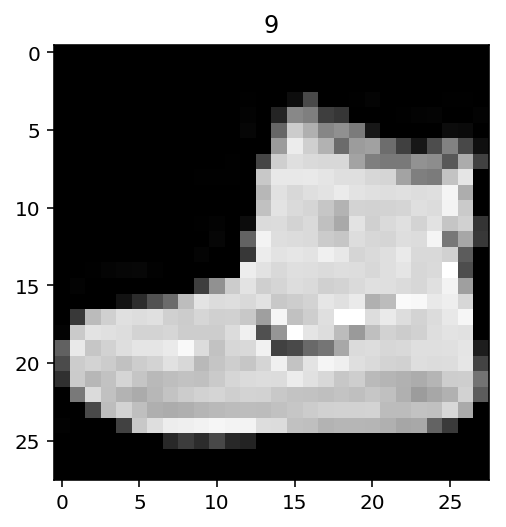

In [39]:
plt.imshow(train_loader.dataset.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_loader.dataset.train_labels[0])
plt.show()

In [40]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.orthogonal(m.weight.data)
        #nn.init.orthogonal(m.bias.data)

In [41]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout_p=0.5):
        super(Net, self).__init__()
        self.dropout_p = dropout_p
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_p, training=self.training)
        x = self.fc3(x)
        
        y = F.log_softmax(x, dim=0)
        return y        

In [42]:
model = Net(input_size, hidden_size, num_classes, dropout_p=0.1)
#apply weigth initialization
#model.apply(weights_init)

if use_gpu:
    model.cuda()
    
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=learning_rate, 
                            weight_decay = 0.0,
                            momentum=0.9)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[70, 90])

In [43]:
%%time
mean_trainloss, std_trainloss = [], []
mean_testloss, std_testloss = [], []
# Train the Model
for epoch in range(num_epochs):
    #Train step
    model.train()
    epoch_trainloss = []
    for train_images, train_labels in train_loader:  
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        # Convert torch tensor to Variable
        train_images = Variable(train_images.view(-1, 28*28))
        train_labels = Variable(train_labels)
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()  # zero the gradient buffer
        train_outputs = model(train_images)
        train_loss = F.nll_loss(train_outputs, train_labels)
        train_loss.backward()
        optimizer.step()
        
        epoch_trainloss.append(train_loss.data[0])
    mean_trainloss.append(np.mean(epoch_trainloss))
    std_trainloss.append(np.std(epoch_trainloss))
    
    scheduler.step()
    
    #Test step
    model.eval()
    epoch_testloss = []
    for test_images, test_labels in test_loader:
        if use_gpu:
            train_images, train_labels = train_images.cuda(), train_labels.cuda()
        test_images = Variable(test_images.view(-1, 28*28), volatile=True)
        test_labels = Variable(test_labels)
        
        #Forward
        test_outputs = model(test_images)
        test_loss = F.nll_loss(test_outputs, test_labels)
        epoch_testloss.append(test_loss.data[0])
    mean_testloss.append(np.mean(epoch_testloss))
    std_testloss.append(np.std(epoch_testloss))
    
    print (f'''Epoch {epoch+1}/{num_epochs}, 
    trainloss: {np.mean(epoch_trainloss)}, 
    testloss : {np.mean(epoch_testloss)}''')

Epoch 1/100, 
    trainloss: 3.0168754255771635, 
    testloss : 2.8065161418914797
Epoch 2/100, 
    trainloss: 2.790818054676056, 
    testloss : 2.7538833236694336
Epoch 3/100, 
    trainloss: 2.7467591710885366, 
    testloss : 2.7300686335563658
Epoch 4/100, 
    trainloss: 2.724201034704844, 
    testloss : 2.726580858230591
Epoch 5/100, 
    trainloss: 2.711042412519455, 
    testloss : 2.7091999650001526
Epoch 6/100, 
    trainloss: 2.6926943612098695, 
    testloss : 2.6991670751571655
Epoch 7/100, 
    trainloss: 2.6810947732130685, 
    testloss : 2.7093623948097227
Epoch 8/100, 
    trainloss: 2.674259184996287, 
    testloss : 2.6934310960769654
Epoch 9/100, 
    trainloss: 2.6662654618422192, 
    testloss : 2.6893646717071533
Epoch 10/100, 
    trainloss: 2.658123415708542, 
    testloss : 2.6799931001663206
Epoch 11/100, 
    trainloss: 2.6516667954126993, 
    testloss : 2.67263126373291
Epoch 12/100, 
    trainloss: 2.648481941620509, 
    testloss : 2.677360904216766

Epoch 99/100, 
    trainloss: 2.522573407491048, 
    testloss : 2.6449660086631774
Epoch 100/100, 
    trainloss: 2.5259541153907774, 
    testloss : 2.645205910205841
CPU times: user 33min 46s, sys: 1min 6s, total: 34min 52s
Wall time: 15min 5s


In [44]:
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
testset_accuracy= round(100*correct/total,2)
print(testset_accuracy)

89.87


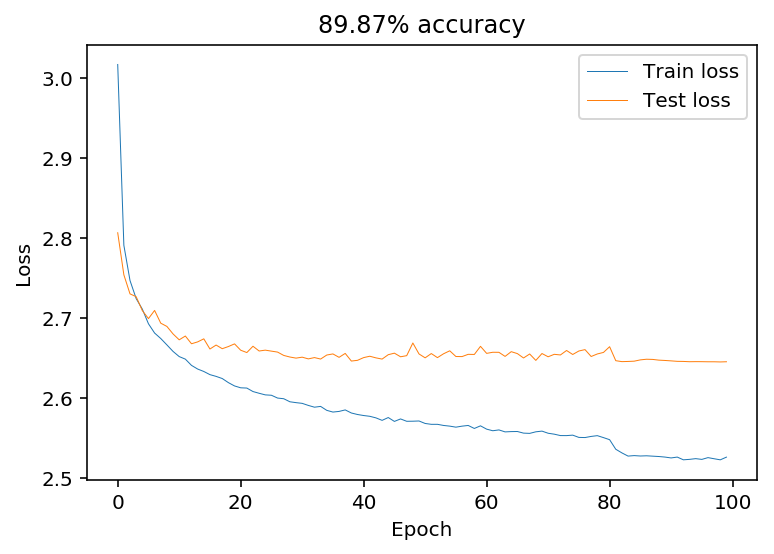

In [45]:
plt.plot(mean_trainloss, label='Train loss',linewidth=0.5)
plt.plot(mean_testloss, label='Test loss', linewidth=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'{testset_accuracy}% accuracy')
plt.legend()
#plt.savefig('300hidden_defaultinit_001lr_weird.pdf', format='pdf')

In [16]:
#torch.save(model.state_dict(),f='onehiddenlayer_200epoch.pt')